### Subsample reference genome catalog

In [1]:
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.distance import DistanceMatrix

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_table('summary.txt.bz2', index_col=0, header=0)
print('Total number of genomes: %d' % df.shape[0])

Total number of genomes: 86200


#### Statistics

In [3]:
def hist_w_max(data, step, xmax):
    """Plot histogram with values > certain threshold combined in one bin."""
    bins = np.arange(0, xmax + step * 2, step)
    plt.xticks(step * np.arange(len(bins)), [str(x) for x in plt.hist(np.clip(data, bins[0],
        bins[-1]), bins=bins)[1]][:-1]+ ['Inf']);

In [4]:
def count_plot(data, percent=False, **kwargs):
    """Plot bars representing categorical counts."""
    ax = sns.countplot(data, **kwargs)
    total = float(len(data))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                '{:1.2f}'.format(height / total) if percent else str(int(height)),
                ha='center')
    ax.set_xlabel('')
    return ax

In [5]:
mpl.rcParams['figure.figsize'] = (9.5, 2.5)

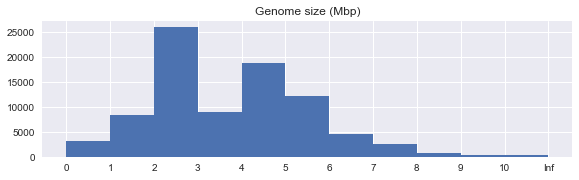

In [6]:
hist_w_max(df['genome_size'] / 1000000, 1, 10)
plt.title('Genome size (Mbp)');

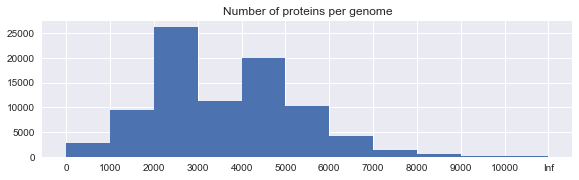

In [7]:
hist_w_max(df['protein_count'], 1000, 10000)
plt.title('Number of proteins per genome');

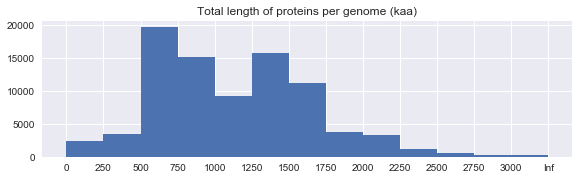

In [8]:
hist_w_max(df['protein_total_length'] / 1000, 250, 3000)
plt.title('Total length of proteins per genome (kaa)');

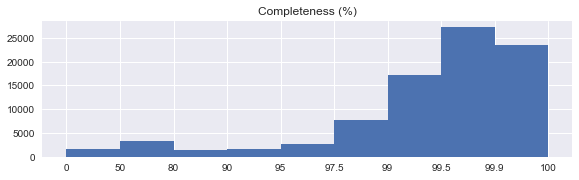

In [9]:
bins = [0, 50, 80, 90, 95, 97.5, 99, 99.5, 99.9, 100]
plt.bar(range(len(bins) - 1), np.histogram(df['completeness'], bins=bins)[0], width=1,
        align='edge')
plt.xticks(np.arange(len(bins)), [str(x) for x in bins])
plt.title('Completeness (%)');

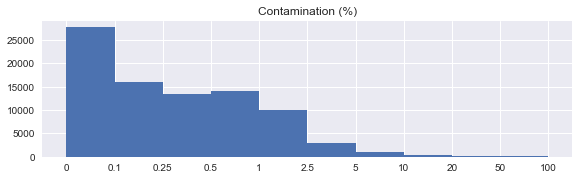

In [10]:
bins = [0, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 20, 50, 100]
plt.bar(range(len(bins) - 1), np.histogram(df['contamination'], bins=bins)[0], width=1,
        align='edge')
plt.xticks(np.arange(len(bins)), [str(x) for x in bins])
plt.title('Contamination (%)');

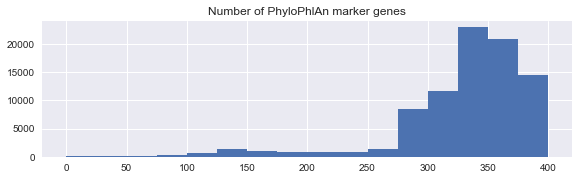

In [11]:
bins = np.arange(0, 425, 25)
plt.hist(df['marker_count'], bins=bins)
plt.title('Number of PhyloPhlAn marker genes');

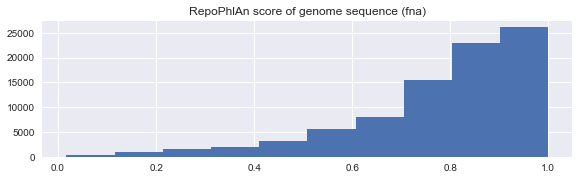

In [12]:
plt.hist(df['score_fna'])
plt.title('RepoPhlAn score of genome sequence (fna)');

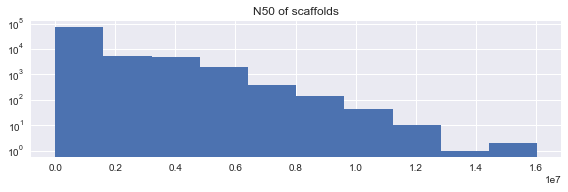

In [13]:
plt.hist(df['n50_scaffolds'], log=True)
plt.title('N50 of scaffolds');

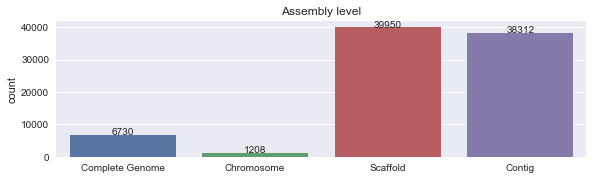

In [14]:
order=['Complete Genome', 'Chromosome', 'Scaffold', 'Contig']
count_plot(df['assembly_level'], order=order).set_title('Assembly level');

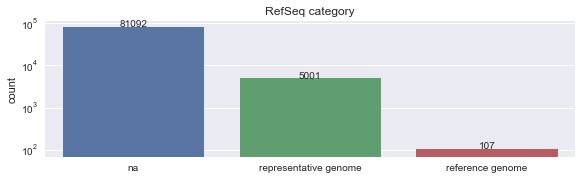

In [15]:
count_plot(df['refseq_category'], log=True).set_title('RefSeq category');

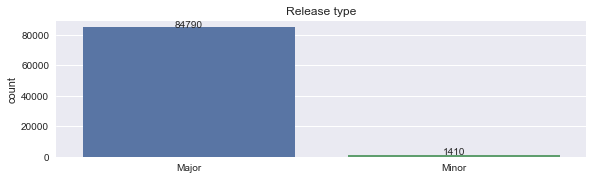

In [16]:
count_plot(df['release_type']).set_title('Release type');

In [17]:
ranks = ['phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']
df[ranks].describe()

,phylum,class,order,family,genus,species,strain
count,85672,81714,80829,80456,80413,86200,27080
unique,153,89,199,429,2117,20780,24966
top,Proteobacteria,Bacilli,Enterobacterales,Enterobacteriaceae,Streptococcus,Staphylococcus_aureus,Mycobacterium_abscessus_subsp_abscessus
freq,37109,25524,13496,11949,10454,7447,447


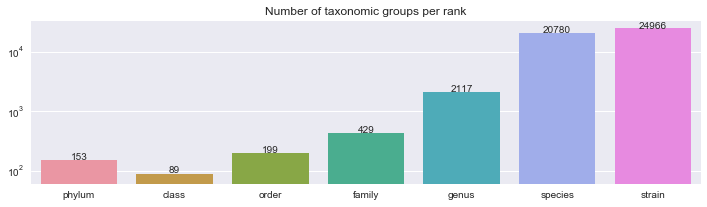

In [18]:
mpl.rcParams['figure.figsize'] = (12, 3)
n_taxa = df[ranks].apply(pd.Series.nunique)
ax = sns.barplot(x=n_taxa.index, y=n_taxa, log=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, str(int(height)), ha='center')
ax.set_xlabel('')
ax.set_title('Number of taxonomic groups per rank');

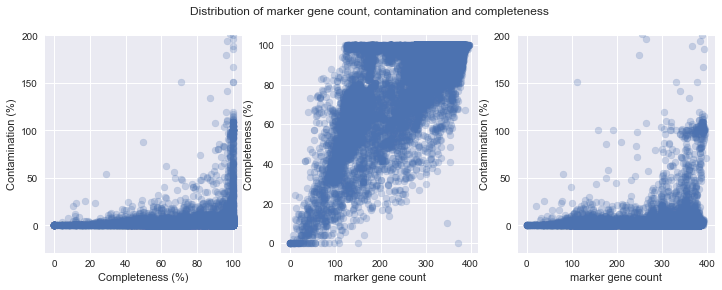

In [19]:
mpl.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(x='completeness', y='contamination', alpha=0.25, data=df)
axarr[0].set_ylim(ymax=200)
axarr[0].set_xlabel('Completeness (%)')
axarr[0].set_ylabel('Contamination (%)');
axarr[1].scatter(x='marker_count', y='completeness', alpha=0.25, data=df)
axarr[1].set_xlabel('marker gene count')
axarr[1].set_ylabel('Completeness (%)');
axarr[2].scatter(x='marker_count', y='contamination', alpha=0.25, data=df)
axarr[2].set_ylim(ymax=200)
axarr[2].set_xlabel('marker gene count')
axarr[2].set_ylabel('Contamination (%)')
plt.suptitle('Distribution of marker gene count, contamination and completeness');

### Criteria for subsampling

In [20]:
dm_fp = '/home/drz/Documents/WoL/subsample/prokaryotes.dm.bz2'
%time dm = DistanceMatrix.read(dm_fp)

CPU times: user 27min 45s, sys: 16.3 s, total: 28min 2s
Wall time: 28min 2s


In [21]:
mpl.rcParams['figure.figsize'] = (12, 2.5)

In [22]:
def examine_set(genomes):
    """Plot statistics of chosen genomes."""
    print('%d' % len(genomes))
    gs = mpl.gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 2])
    cols = ['marker_count', 'completeness', 'contamination', 'score_fna']
    ymaxes = [400, 100, 600, 1.0]
    dfc = df[df.index.isin(genomes)]
    for i, col in enumerate(cols):
        ax = plt.subplot(gs[i])
        ax.plot(dfc[col].sort_values().tolist(), color='C%d' % i)
        ax.set_title(col)
        ax.set_ylim([0, ymaxes[i]])
    m_taxa = df[df.index.isin(genomes)][ranks].apply(pd.Series.nunique)
    p_taxa = m_taxa / n_taxa * 100
    ax = plt.subplot(gs[4])
    sns.barplot(x=p_taxa.index, y=p_taxa, ax=ax)
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, m_taxa[ranks[i]], ha='center')
    ax.set_ylim([0, 110])
    ax.set_xlabel('');
    ax.set_xticklabels(['p', 'c', 'o', 'f', 'g', 's', 't'])
    ax.set_title('% included')
    plt.tight_layout();

86200


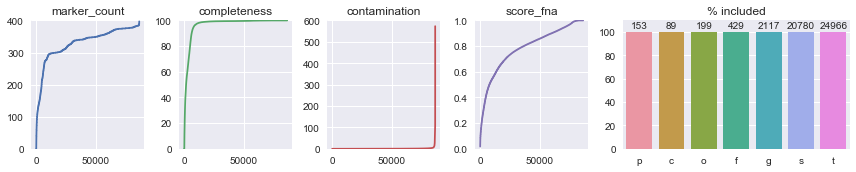

In [23]:
examine_set(df.index)

#### Quality filtering

85498


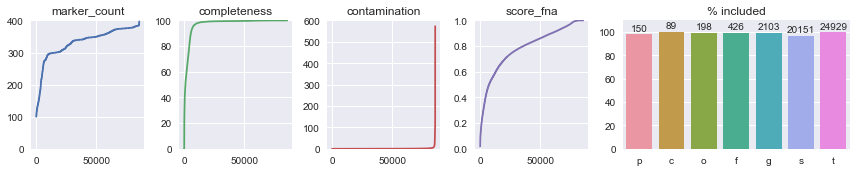

In [24]:
qualified = set(df.query('marker_count >= 100').index.tolist())
examine_set(qualified)

85308


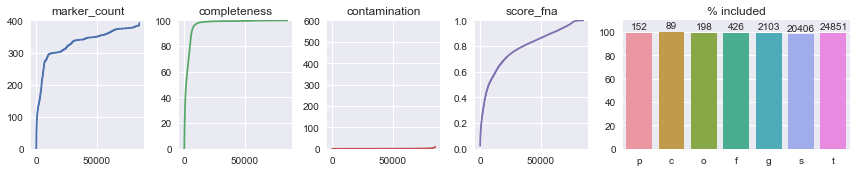

In [25]:
qualified = set(df.query('contamination <= 10').index.tolist())
examine_set(qualified)

81291


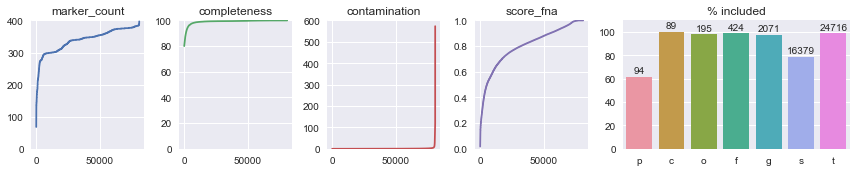

In [26]:
qualified = set(df.query('completeness >= 80').index.tolist())
examine_set(qualified)

#### NCBI reference and representative genomes

5108


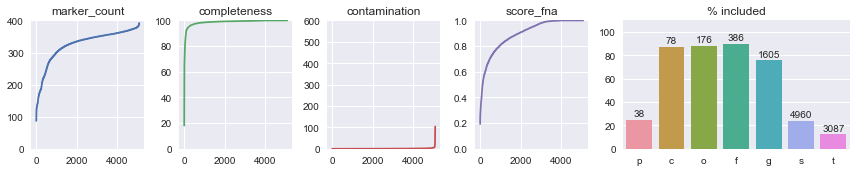

In [27]:
refp = set(df[df['refseq_category'] != 'na'].index.tolist())
examine_set(refp)

#### Only representatives of taxonomic groups

In [28]:
singles = {}
reports = []
for rank in ('phylum', 'class', 'order', 'family', 'genus', 'species'):
    single_taxa = [i for i, val in df[rank].value_counts().iteritems() if val == 1]
    singles[rank] = set(df[df[rank].isin(single_taxa)].index.tolist())
    reports.append('%s: %d' % (rank, len(singles[rank])))
print('Taxonomic groups with only one representative: %s' % ', '.join(reports))

Taxonomic groups with only one representative: phylum: 11, class: 8, order: 29, family: 80, genus: 834, species: 18229


11


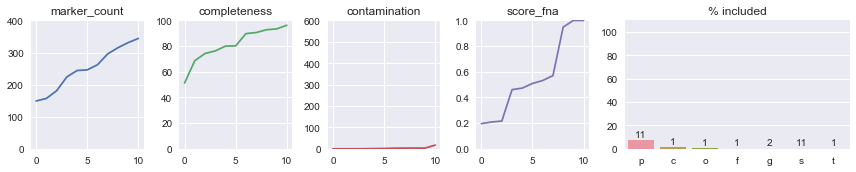

In [29]:
examine_set(singles['phylum'])

8


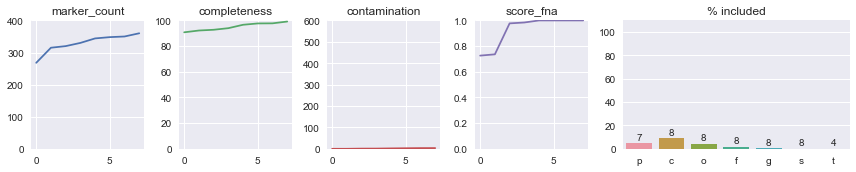

In [30]:
examine_set(singles['class'])

29


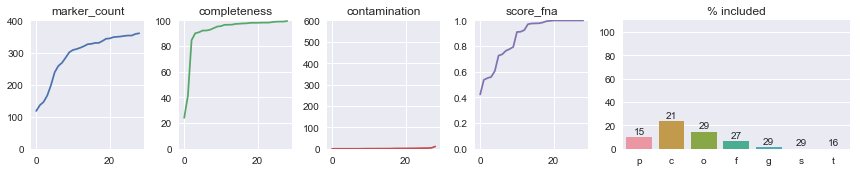

In [31]:
examine_set(singles['order'])

80


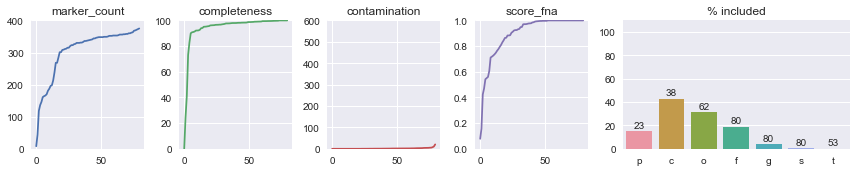

In [32]:
examine_set(singles['family'])

834


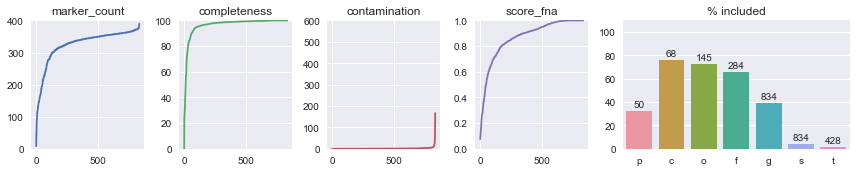

In [33]:
examine_set(singles['genus'])

18229


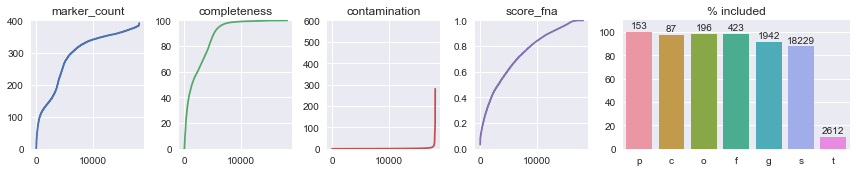

In [34]:
examine_set(singles['species'])

#### No defined taxonomy above species

In [35]:
df_notax = df[df['phylum'].isnull() & df['class'].isnull()
               & df['order'].isnull() & df['family'].isnull()
               & df['genus'].isnull() & df['species'].notnull()]
print('%d genomes belonging to %d species'
      % (df_notax.shape[0], df_notax['species'].nunique()))

519 genomes belonging to 504 species


519


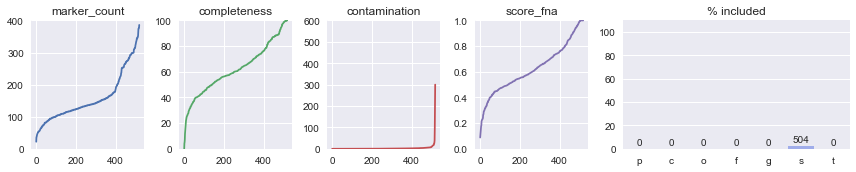

In [36]:
examine_set(df_notax.index)

495


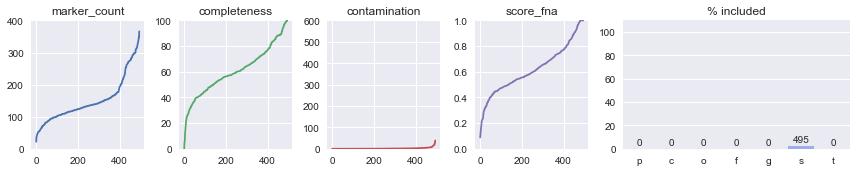

In [37]:
single_notax = df_notax.groupby('species').filter(lambda x: len(x) == 1).index
examine_set(single_notax)

#### Prototype selection

In [38]:
def prototype_selection_destructive_maxdist(dm, num_prototypes, seedset=None):
    """Prototype selection function (minified)."""
    numRemain = len(dm.ids)
    currDists = dm.data.sum(axis=1)
    maxVal = currDists.max()
    if seedset is not None:
        for e in seedset:
            currDists[dm.index(e)] = maxVal * 2
    minElmIdx = currDists.argmin()
    currDists[minElmIdx], numRemain = np.infty, numRemain - 1
    while (numRemain > num_prototypes):
        currDists -= dm.data[minElmIdx]
        minElmIdx = currDists.argmin()
        currDists[minElmIdx], numRemain = np.infty, numRemain - 1
    return [dm.ids[idx]
            for idx, dist in enumerate(currDists)
            if dist != np.infty]

def distance_sum(elements, dm):
    """Calculate sum of distances among chosen genomes."""
    return np.tril(dm.filter(elements).data).sum()

In [39]:
k = 11000  # number of prototypes to keep

In [40]:
%time prototypes = prototype_selection_destructive_maxdist(dm, k)
print('Sum of distances: %d.' % distance_sum(prototypes, dm))

CPU times: user 18.3 s, sys: 36 ms, total: 18.4 s
Wall time: 18.4 s
Sum of distances: 60152796.


11000


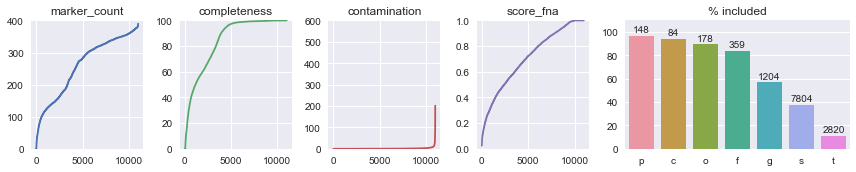

In [41]:
examine_set(prototypes)

### Subsampling plan A

 1. Exclude genomes with contamination > 10% or marker gene count < 100.
 2. Include NCBI reference and representative genomes.
 3. Include only representatives of each phylum to genus.
 4. Include only representatives of each species without defined lineage.
 5. Run prototype selection based on the MinHash distance matrix, with already included genomes as seeds, to obtain a total of 11000 genomes.
 6. For each phylum to genus, and species without defined lineage, select one with highest marker gene count.

In [42]:
chosen = set()

#### Step 1: Exclude genomes with contamination > 10% or marker gene count < 100

In [43]:
dfp = df.query('contamination <= 10 and marker_count >= 100')
print('Genomes passed quality filtering: %d' % dfp.shape[0])

Genomes passed quality filtering: 84617


84617


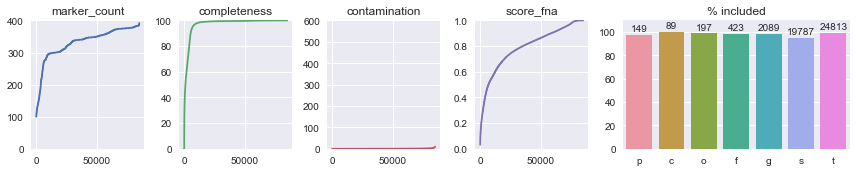

In [44]:
examine_set(dfp.index)

#### Step 2: Include NCBI reference and representative genomes

In [45]:
refp = dfp[dfp['refseq_category'] != 'na'].index
chosen.update(refp)
print('Added NCBI reference and representative genomes: %d' % len(refp))

Added NCBI reference and representative genomes: 5082


5082


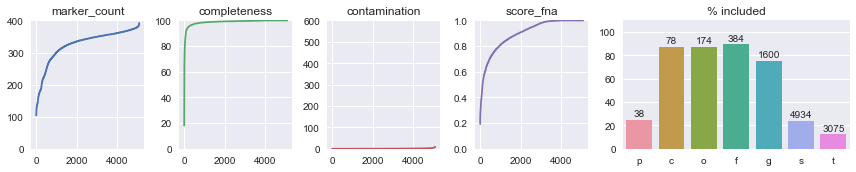

In [46]:
examine_set(chosen)

#### Step 3: Include only representatives of each phylum to genus

In [47]:
reports = []
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    single_taxa = dfp.groupby(rank).filter(lambda x: len(x) == 1).index
    toadd = set(single_taxa) - chosen
    chosen.update(toadd)
    reports.append('%s: %s' % (rank, len(toadd)))
print('Added taxonomic groups: %s' % ', '.join(reports))

Added taxonomic groups: phylum: 14, class: 4, order: 12, family: 14, genus: 333


5459


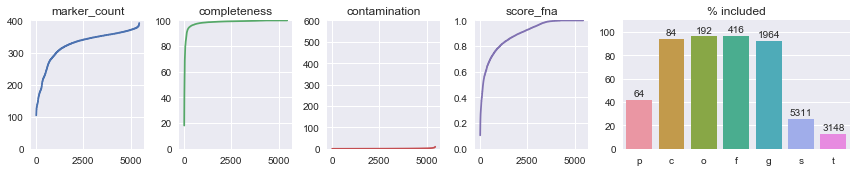

In [48]:
examine_set(chosen)

#### Step 4: Include only representatives of each species without defined lineage

In [49]:
dfp_notax = dfp[dfp['phylum'].isnull() & dfp['class'].isnull()
                & dfp['order'].isnull() & dfp['family'].isnull()
                & dfp['genus'].isnull() & dfp['species'].notnull()]
single_notax = dfp_notax.groupby('species').filter(lambda x: len(x) == 1).index
toadd = set(single_notax) - chosen
chosen.update(toadd)
print('Added species without lineage: %d' % len(toadd))

Added species without lineage: 380


5839


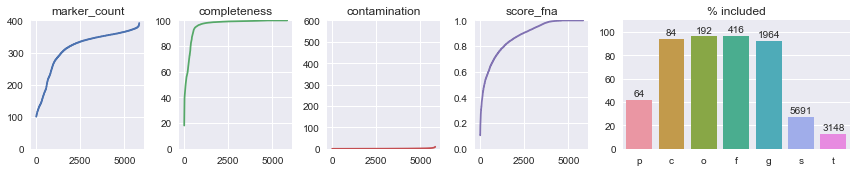

In [50]:
examine_set(chosen)

#### Step 5: Run prototype selection based on the MinHash distance matrix, with already included genomes as seeds, to obtain a total of 11000 genomes

In [51]:
%time dmp = dm.filter(dfp.index).copy()
len(dmp.ids)

CPU times: user 5min 11s, sys: 8min 8s, total: 13min 19s
Wall time: 13min 20s


84617

In [52]:
%time prototypes = prototype_selection_destructive_maxdist(dmp, 11000, chosen)
print('Sum of distances: %d.' % distance_sum(prototypes, dmp))

CPU times: user 19.3 s, sys: 604 ms, total: 19.9 s
Wall time: 20 s
Sum of distances: 59433077.


In [53]:
toadd = set(prototypes) - chosen
chosen.update(toadd)
print('Added prototypes: %d' % len(toadd))

Added prototypes: 5161


11000


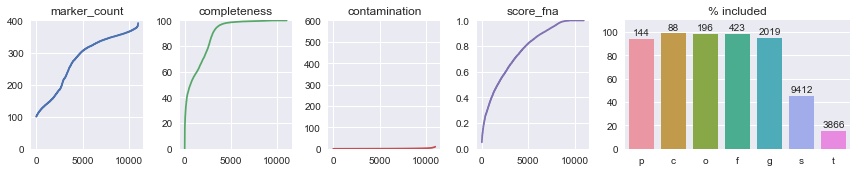

In [54]:
examine_set(chosen)

#### Step 6: For each phylum to genus, and species without defined lineage, select one with highest marker gene count

In [55]:
reports = []
dfc = dfp[dfp.index.isin(chosen)]
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    toadd = set()
    chosen_taxa = dfc[rank].dropna().unique()
    for taxon in dfp[rank].dropna().unique():
        if not taxon in chosen_taxa:
            toadd.add(dfp[dfp[rank] == taxon]['marker_count'].idxmax())
    chosen.update(toadd)
    reports.append('%s: %d' % (rank, len(toadd)))
    dfc = dfp[dfp.index.isin(chosen)]
print('Added taxonomic groups: %s' % ', '.join(reports))

Added taxonomic groups: phylum: 5, class: 1, order: 1, family: 0, genus: 70


In [56]:
toadd = set()
dfc_notax = dfc[dfc.index.isin(dfp_notax.index)]
for species in dfp_notax[~dfp_notax.index.isin(single_notax)]['species'].unique():
    if dfc_notax.query('species == "%s"' % species).shape[0] == 0:
        toadd.add(dfp_notax.query('species == "%s"' % species)['marker_count'].idxmax())
chosen.update(toadd)
dfc = dfp[dfp.index.isin(chosen)]
print('Added species without lineage: %d' % len(toadd))

Added species without lineage: 2


11079


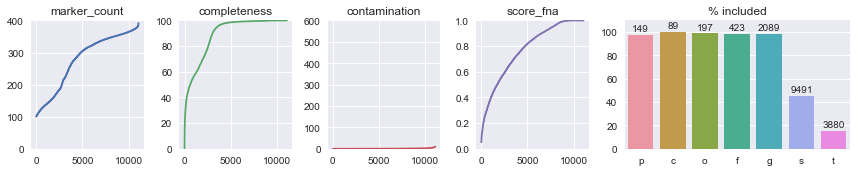

In [57]:
examine_set(chosen)

In [58]:
dfc['marker_count'].describe()

count    11079.000000
mean       278.761441
std         85.486634
min        100.000000
25%        199.000000
50%        315.000000
75%        349.000000
max        392.000000
Name: marker_count, dtype: float64

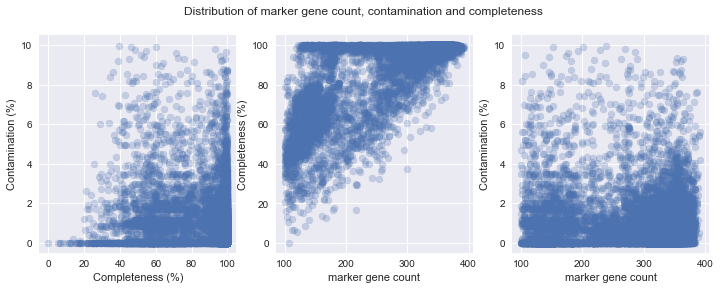

In [59]:
mpl.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(x='completeness', y='contamination', alpha=0.25, data=dfc)
axarr[0].set_xlabel('Completeness (%)')
axarr[0].set_ylabel('Contamination (%)');
axarr[1].scatter(x='marker_count', y='completeness', alpha=0.25, data=dfc)
axarr[1].set_xlabel('marker gene count')
axarr[1].set_ylabel('Completeness (%)');
axarr[2].scatter(x='marker_count', y='contamination', alpha=0.25, data=dfc)
axarr[2].set_xlabel('marker gene count')
axarr[2].set_ylabel('Contamination (%)')
plt.suptitle('Distribution of marker gene count, contamination and completeness');

#### Export results

In [60]:
with open('chosen.txt', 'w') as f:
    for g in sorted(chosen):
        f.write('%s\n' % g)

In [61]:
df['chosen'] = df.index.isin(chosen)

In [62]:
df.to_csv('summary_chosen.tsv', sep='\t')